# EDSA Apple Prices Challenge

Imagine you are in the Fresh Produce Industry. How much stock do you have on hand? Not too little that you run out of stock when customers want to buy more. And not too much that food waste occurs. How do you set your prices? Yields from farms fluctuate by season. Should your prices then also fluctuate by season?

With this context, EDSA is challenging you to construct a regression algorithm, capable of accurately predicting how much a kilogram of Golden Delicious Apples will cost, given certain parameters.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being able to accurately determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

## Data Overview

This dataset consists of over 60 000 sales made by [Durban Fresh Produce Market](http://www.durban.gov.za/Online_Tools/Pages/Fresh_Produce_Price_Reporting.aspx). In this notebook, we use this data to predict the average price per kilogram of Golden Delicious Apples.

Below is a brief description for each data field:
- Province - Which province the produce was grown
- Container - The code for the type of container
- Size_Grade - The class of the produce according to their quality
- Weight_Kg - The total weight in kilograms
- Commodities - The type of produce, e.g. Golden Delicious Apples
- Date - The date of the sale
- Sales_Total - The total sales price
- Total_Qty_Sold - The number of produce sold
- Total_Kg_Sold - The total weight of the produce sold in kilograms
- Stock_On_Hand - The amount of produce the store has

<h1>Table of Contents</h1>
<ul>
    <li><a href="#eda">Exploratiory Data Analysis</a></li>
    <li><a href="#modeldevelopment">Model Development</a></li>
    <li><a href="#modelevaluation">Model Selection</a></li>
    <li><a href="#predictions">Predictions</a></li>
</ul>

In [1]:
# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Model slection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Cross-validation 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Visualisations
#from sklearn.tree import plot_tree
##import missingno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Other
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from scipy import stats
import math
import pickle

<h1 id="eda"> 1) Exploratory Data Analysis   </h1>
<p>

## Basic Analysis

#### We want to investigate what data we obtained from the Durban Fresh Produce Market and how much sales they made during the year 2020.


## 1.1) Loading Data

In [2]:
# import the data
train = pd.read_csv('https://raw.githubusercontent.com/Brighton94/regression-apples-predict-api-template/master/df-train_set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Brighton94/regression-apples-predict-api-template/master/df-test_set.csv')

## 1.2 ) Dataframe visualization

In [3]:
train.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
2,GAUTENG,AT200,1L,20.0,AVOCADO PINKERTON,2020-05-05,70.0,80.0,4860.0,66,1320.0,50,3.68
3,TRANSVAAL,BJ090,1L,9.0,TOMATOES-LONG LIFE,2020-01-20,60.0,60.0,600.0,10,90.0,0,6.67
4,WESTERN FREESTATE,PP100,1R,10.0,POTATO SIFRA (WASHED),2020-07-14,40.0,45.0,41530.0,927,9270.0,393,4.48


## 1.2.1 ) DataFrame Features

In [4]:
print('Table Columns :' ,list(train.columns))

Table Columns : ['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities', 'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg']


In [5]:
train.columns = map(str.lower, train.columns) #for accessability and consistency in analysing the data

### 1.2.2 ) Checking dataframe data type and if Null values exist

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64376 entries, 0 to 64375
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   province          64376 non-null  object 
 1   container         64376 non-null  object 
 2   size_grade        64376 non-null  object 
 3   weight_kg         64376 non-null  float64
 4   commodities       64376 non-null  object 
 5   date              64376 non-null  object 
 6   low_price         64376 non-null  float64
 7   high_price        64376 non-null  float64
 8   sales_total       64376 non-null  float64
 9   total_qty_sold    64376 non-null  int64  
 10  total_kg_sold     64376 non-null  float64
 11  stock_on_hand     64376 non-null  int64  
 12  avg_price_per_kg  64376 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 6.4+ MB


## 1.2.3 ) Dataframe information content

In [7]:
train.shape

(64376, 13)

The data shows that there are 13 feautures which have 64376 observations which were recorded in the year 2020 and Durban Fresh Market. There are 5 ordinal features with 8 quantitative features of which 2 are discrete features. 

Investigating the suppliers that Produce Market has.

In [8]:
commodities=list(train.commodities.unique())
print(commodities)

['APPLE GRANNY SMITH', 'APPLE GOLDEN DELICIOUS', 'AVOCADO PINKERTON', 'TOMATOES-LONG LIFE', 'POTATO SIFRA (WASHED)', 'NOVAS', 'SATSUMAS', 'GARLIC IMPORTED', 'LEMON', 'CUCUMBERS ENGLISH', 'BANANA', 'TOMATOES OTHER', 'APPLE BRAEBURN', 'GRAPE OTHER WHITE', 'BANANA FINGERS SINGLE', 'ONIONS BROWN', 'POTATO PANAMERA', 'POTATO (WASHED) MONDIAL', 'GRAPE MIDNIGHT BEAUTY', 'PEACH OTHER', 'BUTTERNUTS', 'POTATO (WASHED) UP-TO-DATE', 'PEAR PACKHAMS TRIUMPH', 'APPLE GALA', 'SWEET POTATOES ORANGE', 'SWEET POTATOES RED', 'AUTUMN CRUNCH', 'ONIONS MILD', 'ORANGE NAVELS', 'PEAR FORELLE', 'WATERMELON', 'TOMATOES SALADETTE', 'AVOCADO RYAN', 'NADORCOTT', 'POTATO LANORMA (WASHED)', 'ORANGE OTHER', 'APPLE FUJI', 'GRAPEFRUIT STAR RUBY', 'APPLE ROYAL GALA', 'APPLE OTHER', 'PEACH SUMMER SUN', 'TOMATOES JAM', 'BANANA LOWER GRADE (OTHER)', 'GRAPE CRIMSON SEEDLESS', 'APPLE CRIPPS PINK', 'ORANGE VALENCIAS', 'PEACH SPRINGCREST', 'GARLIC PURPLE', 'ONIONS WHITE', 'NECTARINE OTHER', 'NECTARINE AUGUST RED', 'ONIONS RED',

In [9]:
# The number of suppliers 
print(f'The number of supplier that Durban Fresh Produce Market is {len(commodities)}')

The number of supplier that Durban Fresh Produce Market is 270


The Durban Fresh Produce Market has 270 suppliers as indicated by the commodities column. We are only required to predict price for supplier which is Golden Delicious Apple which under Commodities is written as **APPLE GOLDEN DELICIOUS**. We are only going to focus the supplier mentioned from the above.

# 2) Data Processing

## 2.1 Filtering data to only Golden Delicious Apples

In [10]:
#filtering the data to what we need to look at: Golden Delicious Apples
train = train[train['commodities'] == 'APPLE GOLDEN DELICIOUS']
train.head()

,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,APPLE GOLDEN DELICIOUS,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


In [11]:
train.columns

Index(['province', 'container', 'size_grade', 'weight_kg', 'commodities',
       'date', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'avg_price_per_kg'],
      dtype='object')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   province          1952 non-null   object 
 1   container         1952 non-null   object 
 2   size_grade        1952 non-null   object 
 3   weight_kg         1952 non-null   float64
 4   commodities       1952 non-null   object 
 5   date              1952 non-null   object 
 6   low_price         1952 non-null   float64
 7   high_price        1952 non-null   float64
 8   sales_total       1952 non-null   float64
 9   total_qty_sold    1952 non-null   int64  
 10  total_kg_sold     1952 non-null   float64
 11  stock_on_hand     1952 non-null   int64  
 12  avg_price_per_kg  1952 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 213.5+ KB


In [13]:
train.shape

(1952, 13)

The data shows that there are 13 feautures which have 1952 observations which were recorded in the year 2020 and Durban Fresh Market. There are 3 ordinal features namely Province,container and size_grade. There is also 8 numerical features which are continuous

In [14]:
#Rechecking for null values
train.isnull().sum()

province            0
container           0
size_grade          0
weight_kg           0
commodities         0
date                0
low_price           0
high_price          0
sales_total         0
total_qty_sold      0
total_kg_sold       0
stock_on_hand       0
avg_price_per_kg    0
dtype: int64

#### The data has no null/ missing data thus there is no need for data cleaning at the moment.



## 2.2 ) Setting the columns to appropriate data types 


Some of the features such as Date are in an incorrect format or their datatype will make analysis and even prediction more difficult to do. Thus, setting the datatypes is a critical step.

In [15]:
#Set datetime data 
train["date"] = pd.to_datetime(train["date"],format="%Y.%m.%d")

#Set categorical data
train['province'] = train['province'].astype('category')
train['container'] = train['container'].astype('category')
train['size_grade'] = train['size_grade'].astype('category')

The improved dataset with appropriate data types as per feature characteristic:

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   province          1952 non-null   category      
 1   container         1952 non-null   category      
 2   size_grade        1952 non-null   category      
 3   weight_kg         1952 non-null   float64       
 4   commodities       1952 non-null   object        
 5   date              1952 non-null   datetime64[ns]
 6   low_price         1952 non-null   float64       
 7   high_price        1952 non-null   float64       
 8   sales_total       1952 non-null   float64       
 9   total_qty_sold    1952 non-null   int64         
 10  total_kg_sold     1952 non-null   float64       
 11  stock_on_hand     1952 non-null   int64         
 12  avg_price_per_kg  1952 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(6), int64(2), object(1)
memory usa

## 2.4 ) Checking for outliers

### 2.4.1) Checking for outliers using Kurtosis and Skewness


 Skweness and the kurtosis value tells us how distributed and symmetrical the data is.
 
 Ideally  it is desired to a data with a kurtosis of less than 3 : a normally distributed data                       And also the data to be have a skewness between -1 and 1 : moderately symmetrical 


In [17]:
#checking data symmetry using skewness
train.skew()

weight_kg           3.328254
low_price           4.222672
high_price          3.828819
sales_total         4.250317
total_qty_sold      4.445169
total_kg_sold       5.529586
stock_on_hand       3.391815
avg_price_per_kg    0.082452
dtype: float64

In [18]:
#checking data kurtosis
train.kurt()

weight_kg            9.109698
low_price           17.073369
high_price          13.630768
sales_total         24.200524
total_qty_sold      32.338123
total_kg_sold       45.153801
stock_on_hand       14.671224
avg_price_per_kg     1.042921
dtype: float64

###  Observations

It is observed that:
 * All of our features except for the average price per kg are extremely positive skewed indicate by the values being 
   greater than 1.
 * The Average price per kg feature which is our target variable is fairly symetrical the skew value of 0.082452 is between -0.5 and 0.5
 
 * There is a high number of outliers present in our observations as we have observed high kurtosis(**>3**) for all the features except for the target feature,avg_price_per_kg with kurtosis value 1.042921.

### 2.4.2) Checking for outliers using descriptive statistics

In [19]:
#Descriptive Statistics
train.describe()

,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


### Observation 

From observing the numerical data there are many errors in the data :
* The mean of the features is quite distinct from the median which indicates there are outliers present


## 2.5 ) Outliers treatment

###  Data visualization before removing outlier

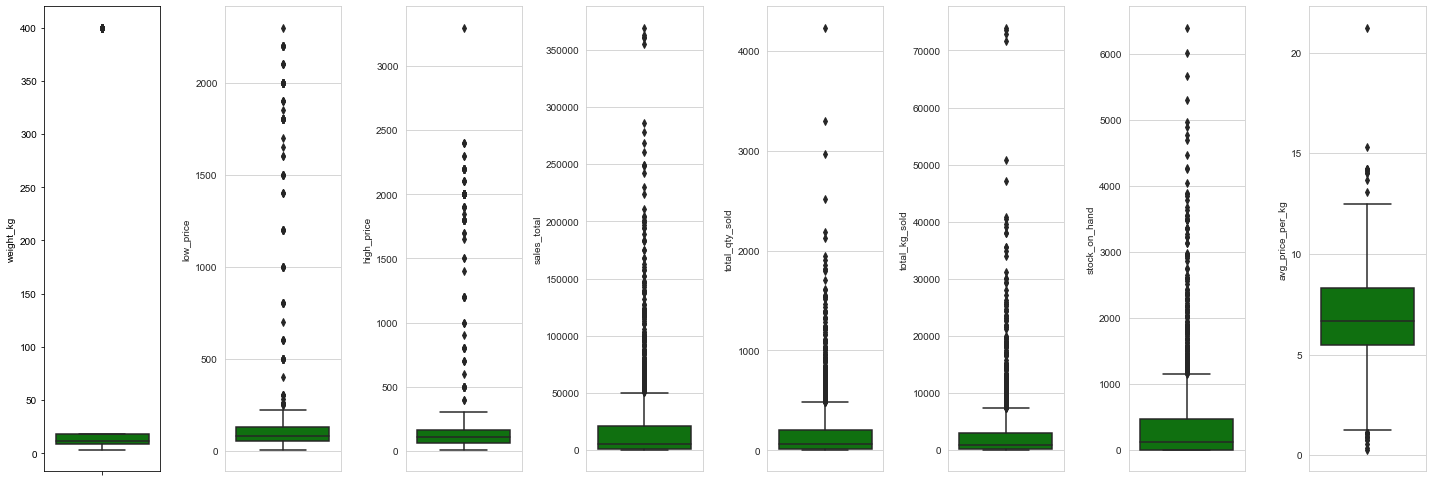

In [20]:

col_sel =['weight_kg','low_price','high_price','sales_total','total_qty_sold','total_kg_sold', 'stock_on_hand', 'avg_price_per_kg']

plt.figure(figsize=(20,60))
for index in range(0,len(col_sel)):
    plt.subplot(len(col_sel )+ 1,len(col_sel ),index+1)
    sns.set_style('whitegrid')
    sns.boxplot(y=train[col_sel[index]],data= train,color='green')
    plt.tight_layout()


### 2.5.1 ) Removing outlier using Interquartile range score method

Values outside the IQR*1.5 boundary fence will be replace with the median of observations , because median is not affected by outliers

In [21]:

col_sel =['weight_kg','low_price','high_price','sales_total','total_qty_sold','total_kg_sold', 'stock_on_hand', 'avg_price_per_kg']
df_in=train  

for col_name in col_sel :
    
    q1 =np.percentile(df_in[col_name], 25)
        
    q3=np.percentile(df_in[col_name], 75)
    
    iqr = q3-q1 #Interquartile range
    low_  = q1-1.5*iqr
    high_ = q3+1.5*iqr
    
    for i in range(len(df_in)):
        if df_in.iloc[i][col_name]<low_ or df_in.iloc[i][col_name]>high_:
            df_in.iloc[i][col_name]= train[col_name].median()
            
            
train=df_in            
 




C:\Users\vnbri\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


### 2.5.2 ) Removing outlier using Z -  score method

In [22]:
Before_removal = train.shape[0]

In [23]:
threshold = 3 #Z_score threshold

col_sel =['weight_kg','low_price','high_price','sales_total','total_qty_sold','total_kg_sold', 'stock_on_hand', 'avg_price_per_kg']
df_=train
for col_nam in col_sel :
    Z_score =np.abs(stats.zscore(df_[col_nam]))
    df_=df_[np.abs(Z_score) < threshold]
    
train = df_  

In [24]:
After_removal = train.shape[0]

In [25]:
print('Number of data before removal : ' ,Before_removal)
print('Number of data after removal : ' ,After_removal)
print('Tota number of outliers removed :',Before_removal-After_removal)

Number of data before removal :  1952
Number of data after removal :  1644
Tota number of outliers removed : 308


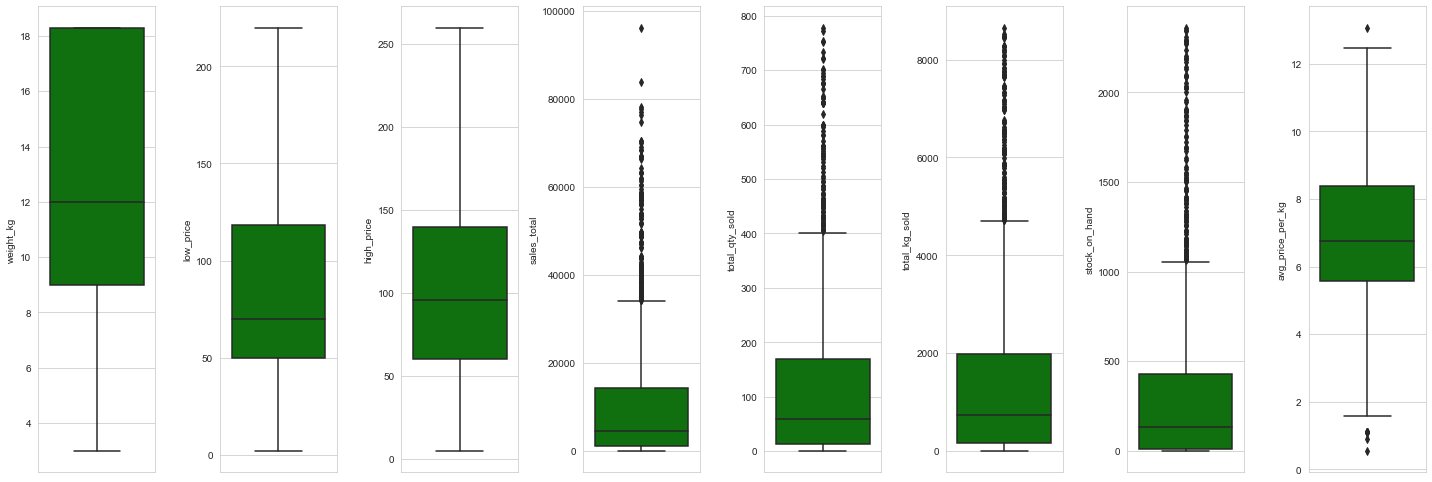

In [26]:
col_sel =['weight_kg','low_price','high_price','sales_total','total_qty_sold','total_kg_sold', 'stock_on_hand', 'avg_price_per_kg']

plt.figure(figsize=(20,60))
for index in range(0,len(col_sel)):
    plt.subplot(len(col_sel )+ 1,len(col_sel ),index+1)
    sns.set_style('whitegrid')
    sns.boxplot(y= train[col_sel[index]],data = train,color='green')
    plt.tight_layout()

# 3) Exploratory Data Analysis 

## 3.1) Univariate Analysis: Non-Graphical

### 3.1.1) For the numerical data:


To check the distribution of the data: 

In [27]:
train.describe()

,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
count,1644.000000,1644.000000,1644.000000,1644.000000,1644.000000,1644.000000,1644.000000,1644.000000
mean,12.742640,84.369221,102.372263,10779.321776,118.315693,1494.513990,319.843674,6.918425
std,4.048532,45.477576,52.496762,14792.191679,148.502259,1906.601324,452.675560,2.110512
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.550000
25%,9.000000,50.000000,60.000000,1053.750000,13.000000,164.700000,11.750000,5.560000
50%,12.000000,70.000000,96.000000,4480.000000,60.000000,732.000000,134.000000,6.745000
75%,18.300000,118.500000,140.000000,14294.000000,169.250000,1984.050000,430.000000,8.392500
max,18.300000,220.000000,260.000000,96260.000000,778.000000,8655.900000,2361.000000,13.070000


### 3.1.2) For Categorical Data:

In [28]:
train.describe(include=['category'])

,province,container,size_grade
count,1644,1644,1644
unique,7,10,10
top,CAPE,JE090,1S
freq,814,551,329


The categorical data description shows us the mode which is indicated by top and the frequncy of data. The data show that most apples came from Cape province which had the size_grad of 1S and most of the stored in the container: M4183.

## 3.2) Univariate Analysis: Graphical

In [29]:
sns.set_style('whitegrid')

### 3.2.1) Numerical Features:

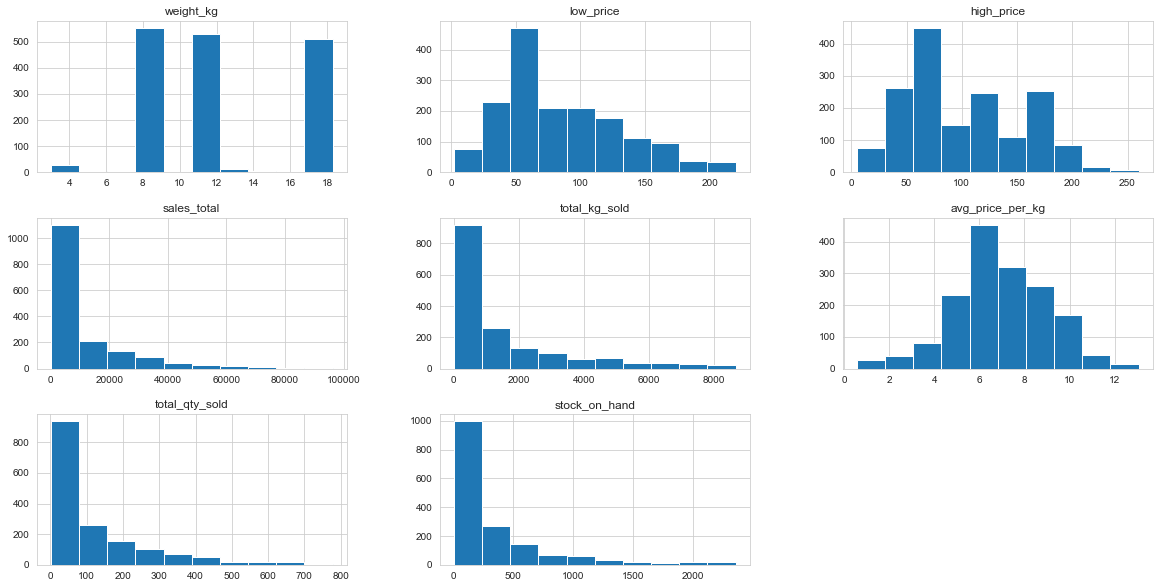

In [30]:
numerical_features =list(train.select_dtypes(include=['float64']).columns)
numerical_features = numerical_features +list(train.select_dtypes(include=['int64']).columns)

train[numerical_features].hist()
plt.gcf().set_size_inches(20, 10)

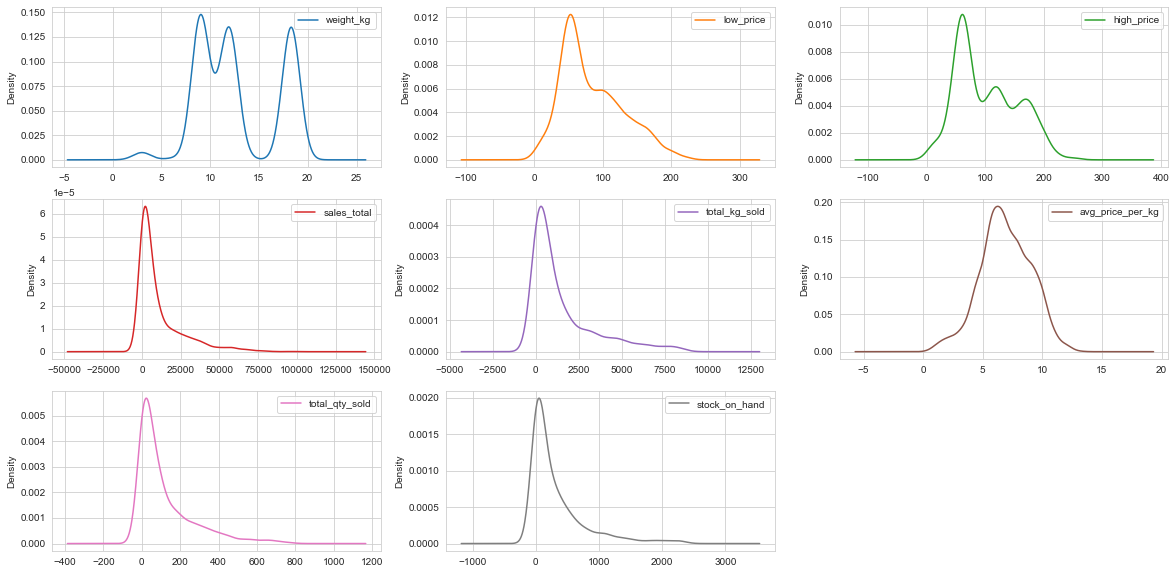

In [31]:
train[numerical_features].plot(kind='density', subplots=True, layout=(3, 3), sharex=False)

plt.gcf().set_size_inches(20, 10)

The observations from the above graphs indicate to us that most of the is mostly skewed like for the features like sales_total, total_kg_sold,total_qty_sold,stock_on_hand. The weight_kg feauture appeared to have a bimodal curve whereas the rest of the feautures including the target seem to have normal distribution  

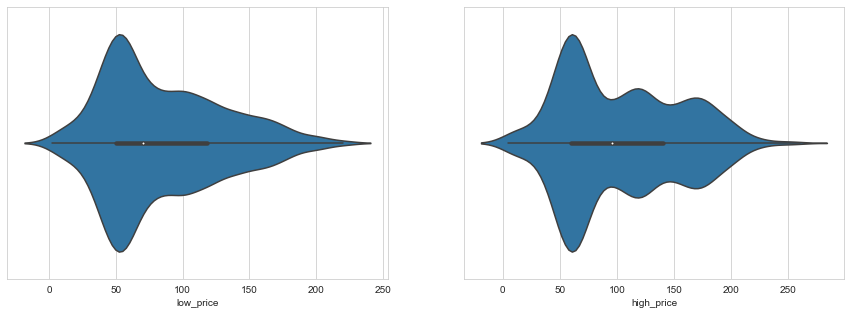

In [32]:
fig, ax =plt.subplots(1,2)
sns.violinplot(x = 'low_price', data = train,ax=ax[0])
sns.violinplot(x = 'high_price', data = train,ax=ax[1])
#sns.violinplot(x = 'avg_price_per_kg',data = train, ax=ax[2])
plt.gcf().set_size_inches(15, 5)


The general low price of apples produced Golden Delicious Apples was around 50.00 whereas the high price was around 60.00. This is seen by the distribution of the prices respectively.

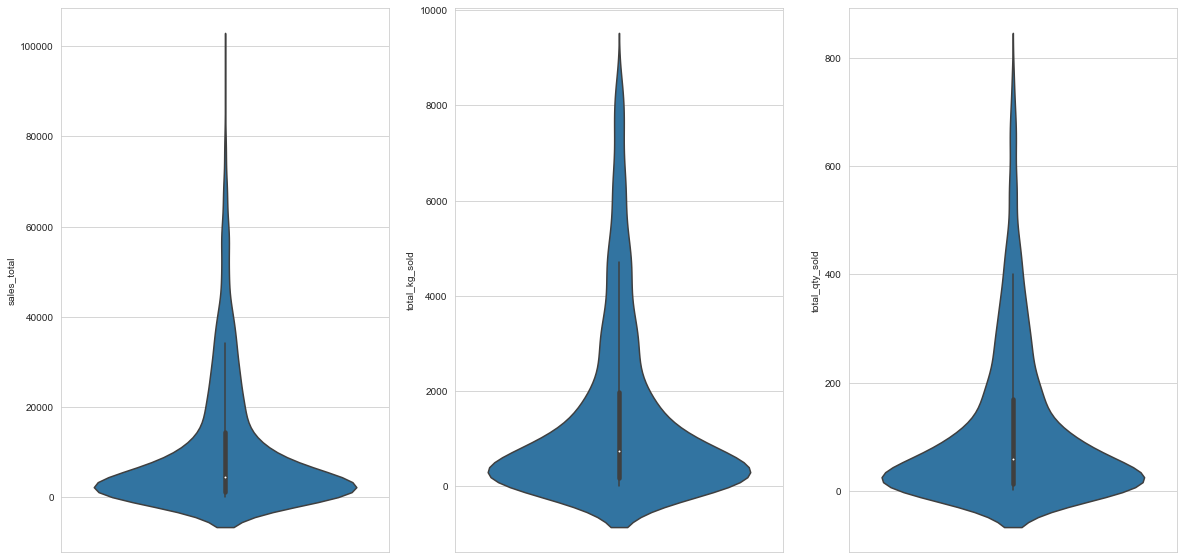

In [33]:
fig, ax =plt.subplots(1,3)
sns.violinplot(y = 'sales_total', data = train,ax=ax[0])
sns.violinplot(y = 'total_kg_sold', data = train,ax=ax[1])
sns.violinplot(y = 'total_qty_sold', data = train,ax=ax[2])
plt.gcf().set_size_inches(20, 10)


The Produce Market general sales of the Golden Delicious Apples produce is shown by these graphs above.   

### 3.2.2) Categorical Features:

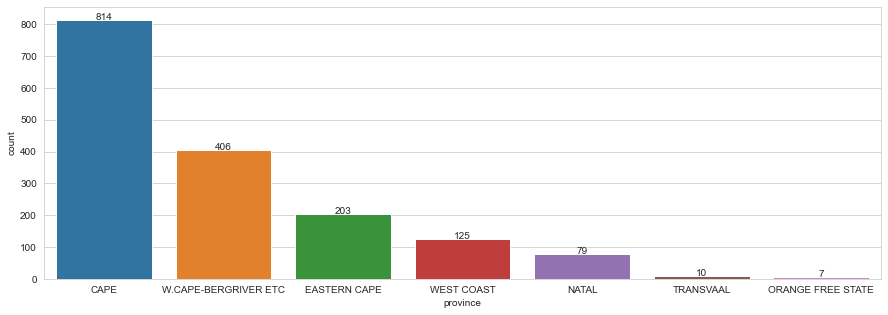

In [34]:
graph = sns.countplot(x = 'province',data = train,order = train['province'].value_counts().index)

graph.set_xticklabels(graph.get_xticklabels(),rotation=0)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.gcf().set_size_inches(15, 5)

posx and posy should be finite values
posx and posy should be finite values


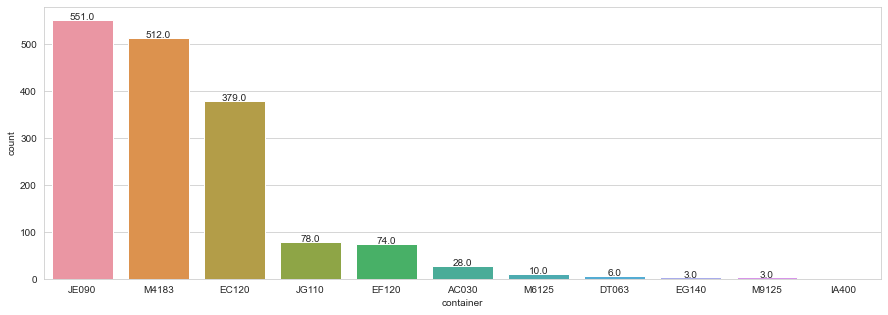

In [35]:
graph = sns.countplot(x = 'container', data = train,order = train['container'].value_counts().index)

graph.set_xticklabels(graph.get_xticklabels(),rotation=0)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
    
plt.gcf().set_size_inches(15, 5)


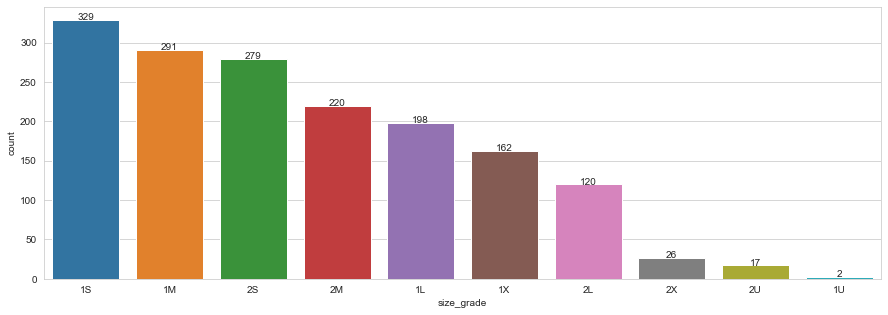

In [36]:
graph = sns.countplot(x = 'size_grade', data = train,order = train['size_grade'].value_counts().index)

graph.set_xticklabels(graph.get_xticklabels(),rotation=0)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
    
plt.gcf().set_size_inches(15, 5)

## 3.3) Target Feature Analysis : Average price per kg

The target feature is the average price per kg of the Golden Delicous Apples
 * non graphical analysis
 * graphical analysis
 
 
 

### 3.3.1) Non-Graphical Analysis

In [37]:
train.avg_price_per_kg.describe().round(decimals=2)


count    1644.00
mean        6.92
std         2.11
min         0.55
25%         5.56
50%         6.74
75%         8.39
max        13.07
Name: avg_price_per_kg, dtype: float64

In [38]:
train.avg_price_per_kg.mode()

0    6.67
dtype: float64

In [39]:
train.avg_price_per_kg.skew()

-0.1184370592100963

What we have observed from the target feature is that most apples were sold at 6.67 per kg which is consistent with the mean and median.

In [40]:
### 3.3.2) Graphical Analysis

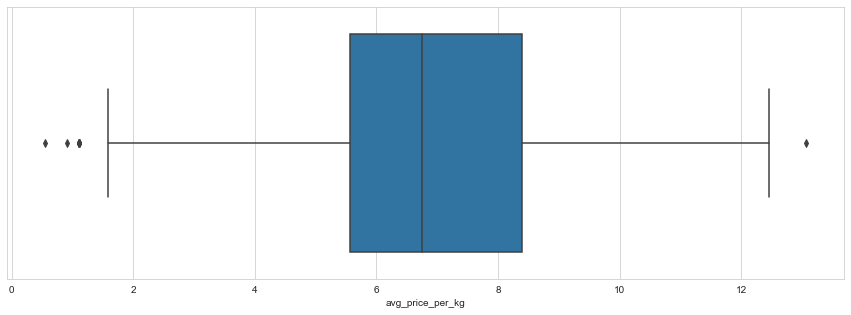

In [41]:
sns.boxplot(x = 'avg_price_per_kg', data = train)
plt.gcf().set_size_inches(15, 5)

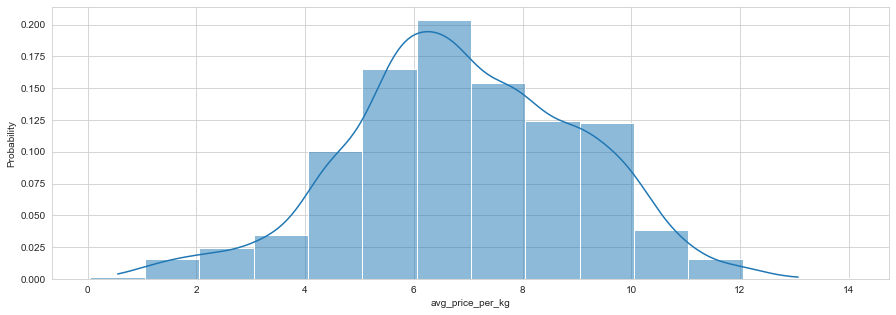

In [42]:
sns.histplot(data=train, x="avg_price_per_kg", stat="probability", discrete=True, kde = True)
plt.title 
plt.gcf().set_size_inches(15, 5)

The data of the avg_price_per_kg indicates that it is normally distributed. The data has few outliers and indicates that around 68.27% of the apple's produced Golden Delicious Apple prices per kg are between 4.81 and 9.03 and 95.45% of the prices are in the range 2.07 and 11.14.

## 3.4) Multivariate Analysis: Non-Graphical 

### 3.4.1)  Numerical Features

In [43]:
train.corr()

,weight_kg,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
weight_kg,1.000000,0.791416,0.881097,0.283996,-0.021869,0.216725,0.114434,0.492831
low_price,0.791416,1.000000,0.873212,0.198306,-0.096507,0.074110,0.037077,0.818421
high_price,0.881097,0.873212,1.000000,0.384051,0.060717,0.271911,0.164287,0.766020
sales_total,0.283996,0.198306,0.384051,1.000000,0.842420,0.957746,0.261949,0.260869
total_qty_sold,-0.021869,-0.096507,0.060717,0.842420,1.000000,0.929742,0.243735,0.005518
total_kg_sold,0.216725,0.074110,0.271911,0.957746,0.929742,1.000000,0.268349,0.109279
stock_on_hand,0.114434,0.037077,0.164287,0.261949,0.243735,0.268349,1.000000,0.079668
avg_price_per_kg,0.492831,0.818421,0.766020,0.260869,0.005518,0.109279,0.079668,1.000000


The above tables shows us if the numerical features are correlated with eachother or is correlated with the target feature:avg_price_per_kg. 

### 3.4.2) Multivariate Analysis: Graphical

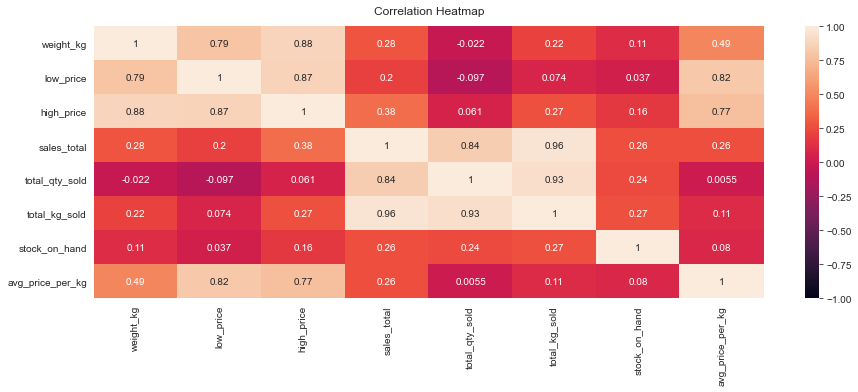

In [44]:
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.gcf().set_size_inches(15, 5)

The heatmap is an extension and a visualisation of the correlation table above. From both the table and the heat map I can conlude that :
* The Low_Price and High_Price features are highly correlated to the target feature,the Weight_kg  feature as well as to each other.This hints about collinearity between the two variables but the is not sufficient evidence. These features are both negatively correlated to Total_Qty_Sold. This is indicates that weight affects the prices of the apples.
* The Sales_total feature is highly correlated to the Total_qty_sold feature and the Total_kg_sold. How many apples sold determines how much sales made.


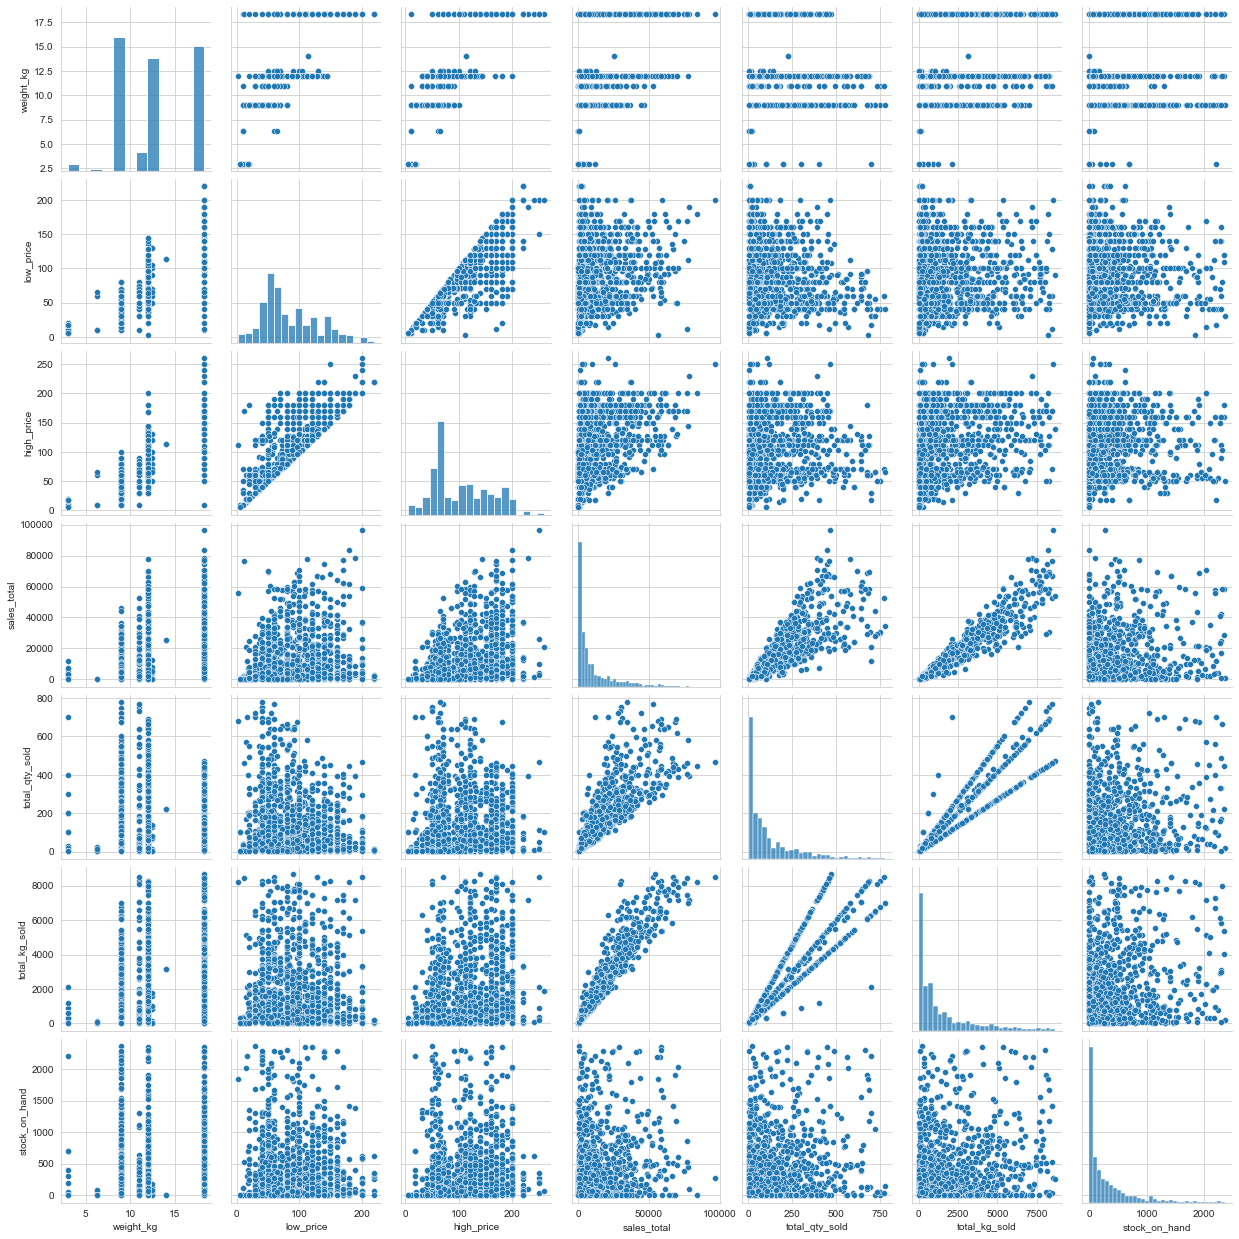

In [45]:
train2 = train.drop('avg_price_per_kg', axis = 1)

sns.pairplot(train2)


This pair plot shows us which features are correlated to eachother. This also serves as an extension of the heatmap. We are concluding that there is some collinearity present thus we will not use the Multiple Linear Regression as model.

### 3.4.2.1) Correlation between features and the target feature

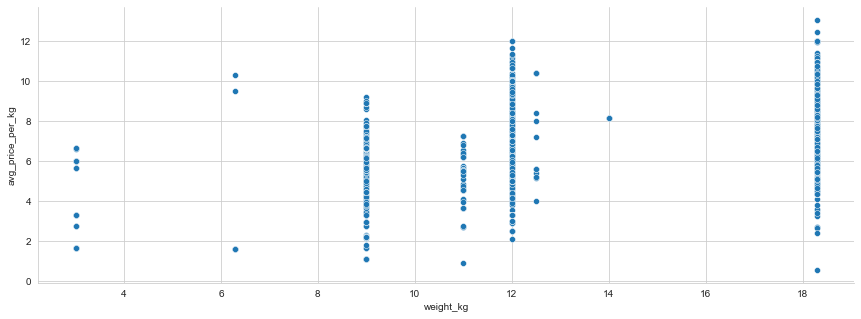

In [46]:
g = sns.FacetGrid(train)
g.map(sns.scatterplot, "weight_kg", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(15, 5)

The Weight_kg feature moderately correlated to the target feature. This means that the higher the weight, higher the average price.

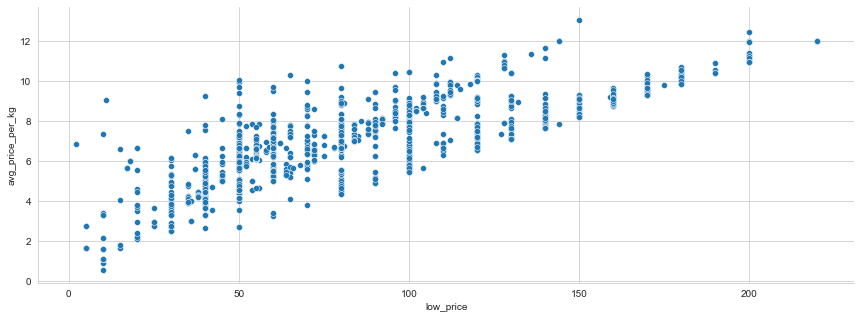

In [47]:
g = sns.FacetGrid(train)
g.map(sns.scatterplot, "low_price", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(15, 5)

The Low_price feature is highly correlated to the target. This shows that the lower price of the apples the higher the average price of the apples 

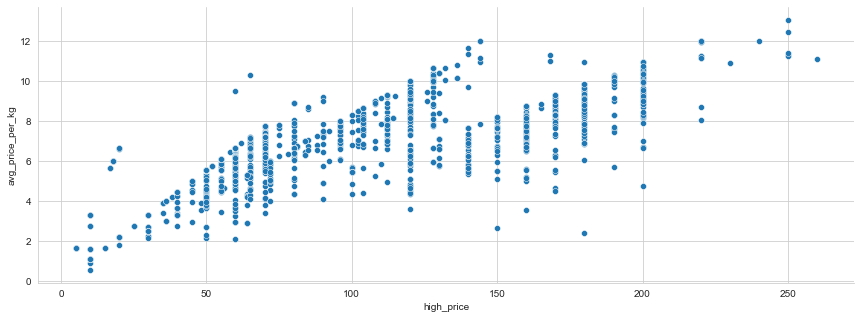

In [48]:
g = sns.FacetGrid(train)
g.map(sns.scatterplot, "high_price", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(15,5)

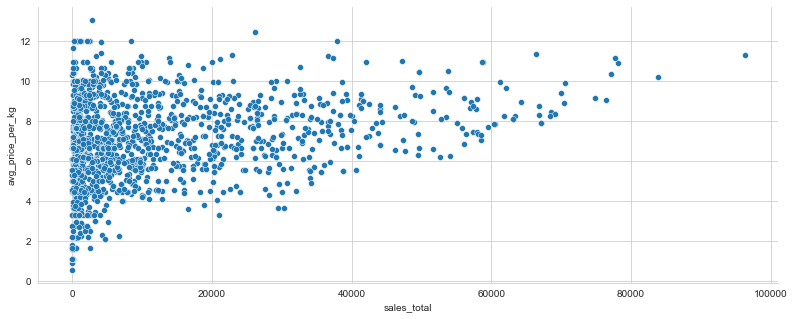

In [49]:
g = sns.FacetGrid(train)
g.map(sns.scatterplot, "sales_total", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(15, 5)

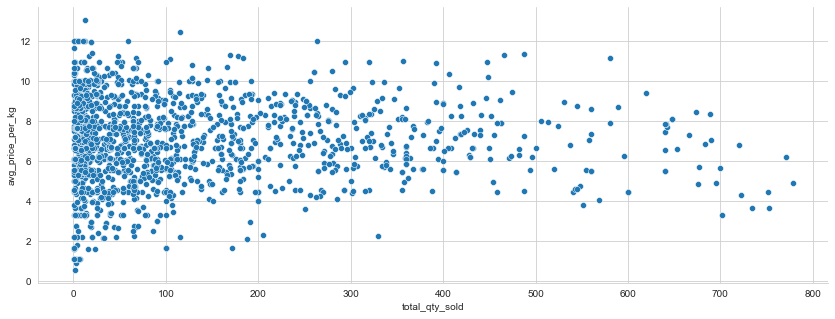

In [50]:
g = sns.FacetGrid(train)
g.map(sns.scatterplot, "total_qty_sold", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(15, 5)

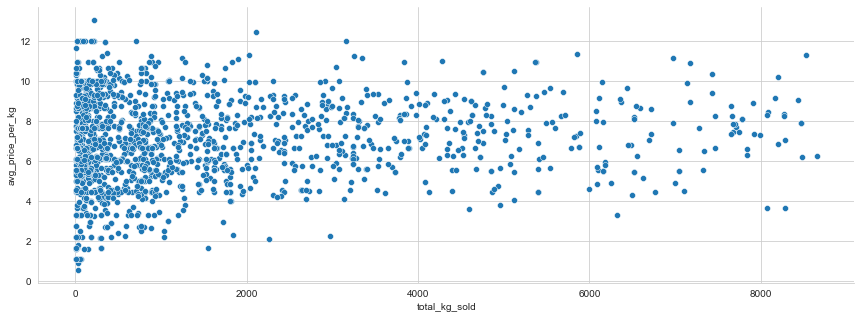

In [51]:
g = sns.FacetGrid(train)
g.map(sns.scatterplot, "total_kg_sold", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(15, 5)

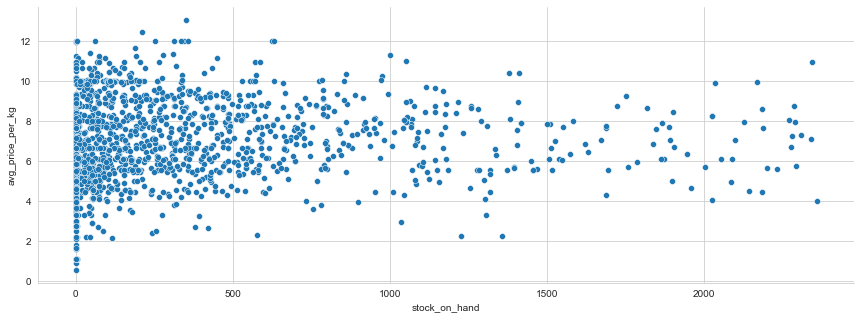

In [52]:
g = sns.FacetGrid(train)
g.map(sns.scatterplot, "stock_on_hand", "avg_price_per_kg", alpha=1)
plt.gcf().set_size_inches(15, 5)

### 3.4.2.3) Time-Series graphs

We want to observe how each numerical feature changed over the period 

In [53]:
train3 = train
train3['month'] = train3['date'].dt.month

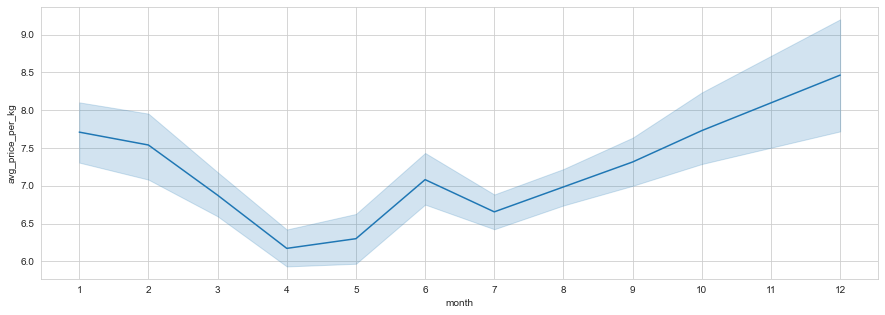

In [54]:
sns.lineplot(x="month", y="avg_price_per_kg",
             data=train3)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.gcf().set_size_inches(15, 5)

As we can see from the plot, there is an upward trent from month 7.

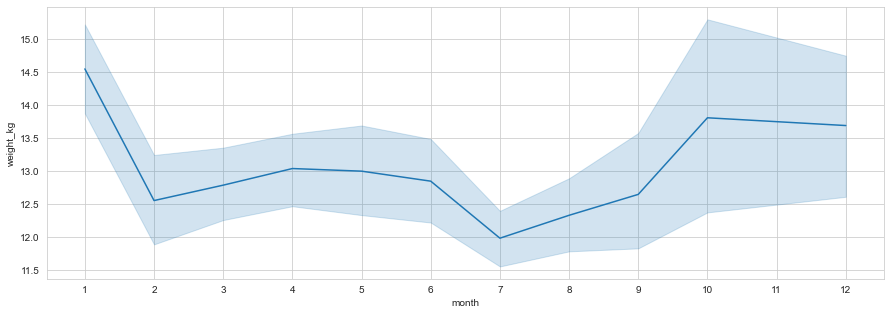

In [55]:
sns.lineplot(x="month", y="weight_kg",data=train3)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.gcf().set_size_inches(15, 5)

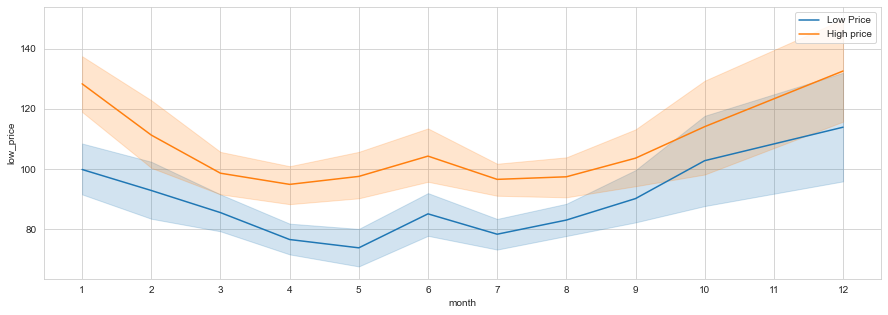

In [56]:
sns.lineplot(x="month", y="low_price",data=train3)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.gcf().set_size_inches(15, 5)

sns.lineplot(x="month", y="high_price",data=train3)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.gcf().set_size_inches(15, 5)
plt.legend(labels=['Low Price', 'High price'])


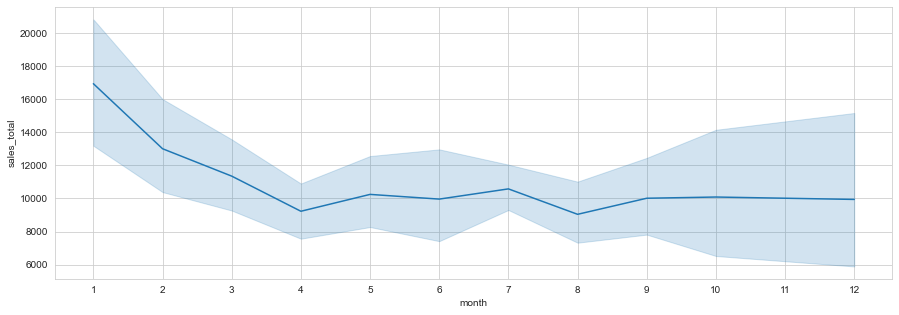

In [57]:
sns.lineplot(x="month", y="sales_total",data=train3)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.gcf().set_size_inches(15, 5)

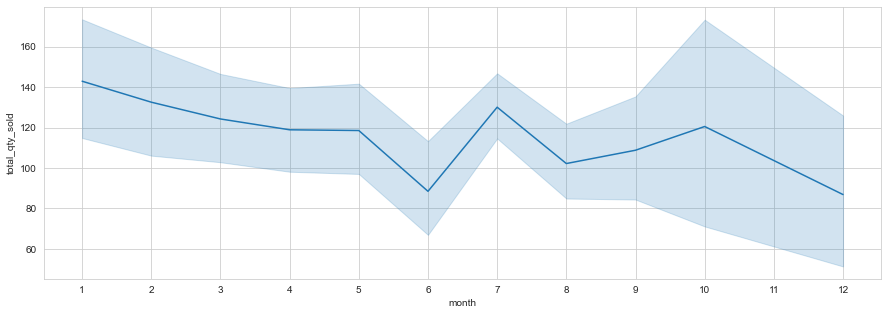

In [58]:
sns.lineplot(x="month", y="total_qty_sold",data=train3)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.gcf().set_size_inches(15, 5)

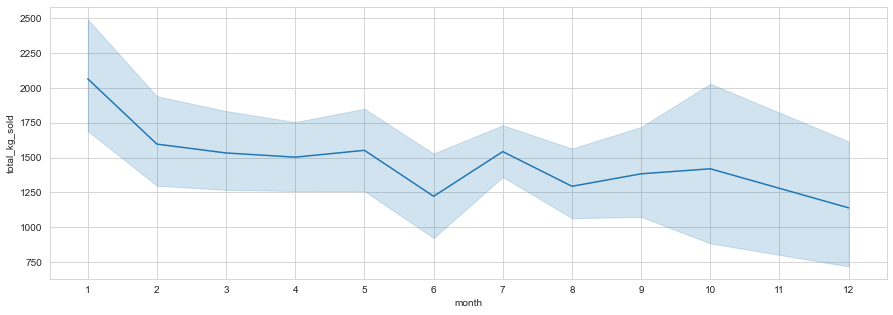

In [59]:
sns.lineplot(x="month", y="total_kg_sold",data=train3)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.gcf().set_size_inches(15, 5)

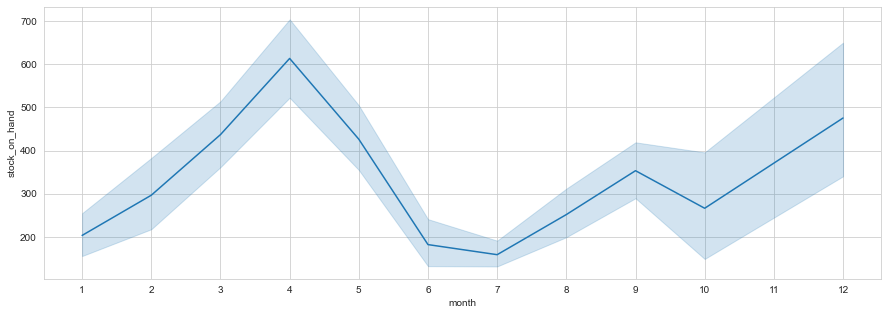

In [60]:
sns.lineplot(x="month", y="stock_on_hand",data=train3)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.gcf().set_size_inches(15, 5)

### 3.4.3 Categorical Features

#### Graphical Analysis

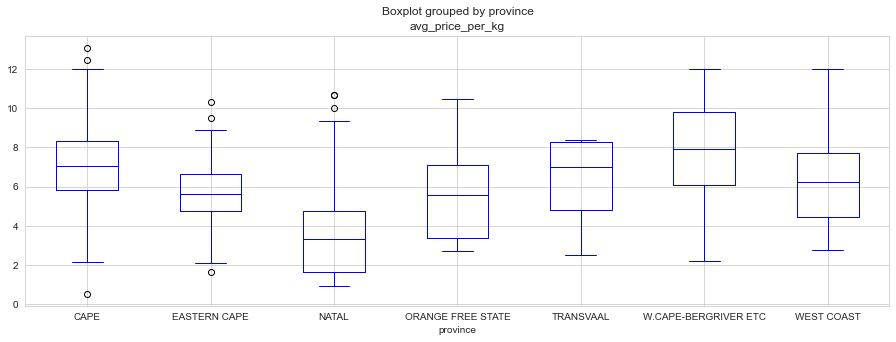

In [61]:
train3.boxplot("avg_price_per_kg","province",color = 'b')
plt.gcf().set_size_inches(15, 5)


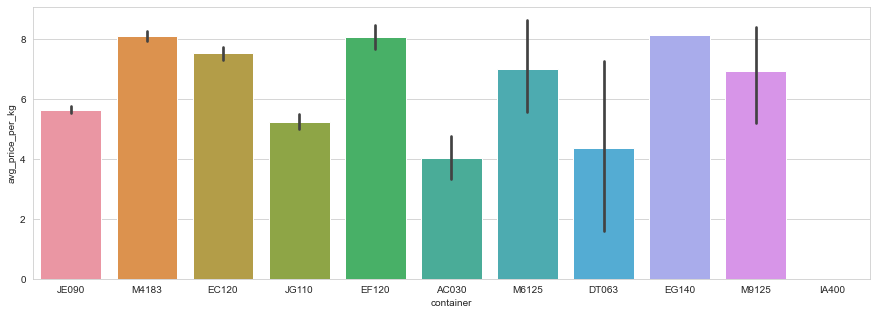

In [62]:
sns.barplot(x="container", y="avg_price_per_kg", data=train3,order = train['container'].value_counts().index)
plt.gcf().set_size_inches(15, 5)

The average price per kg for each container varies. This is a good thing, because we can be able use our `'container'` feature to make predictions about the `'avg_price_per_kg'` response variable. This can later be verified with the ANOVA test.

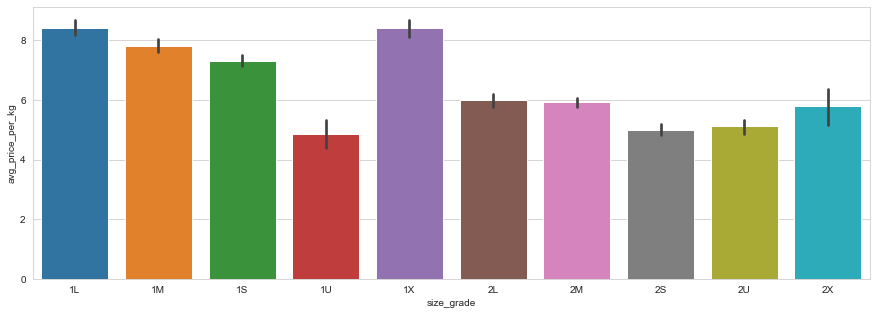

In [63]:
sns.barplot(x="size_grade", y="avg_price_per_kg", data=train3)
plt.gcf().set_size_inches(15, 5)

The average price per kg for each size/grade varies. This is a good thing, because we can be able use our `'size_grade'` feature to make predictions about the `'avg_price_per_kg'` response variable. This can later be verified with the ANOVA test.

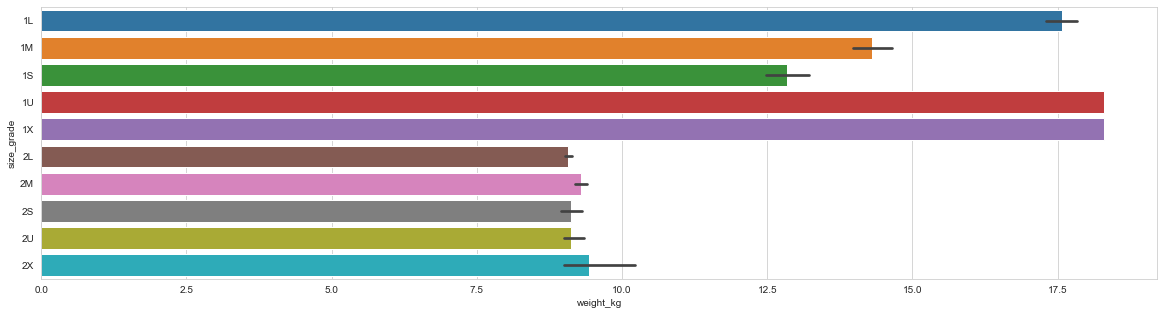

In [64]:
sns.barplot(y="size_grade", x="weight_kg", data=train3)
plt.gcf().set_size_inches(20, 5)

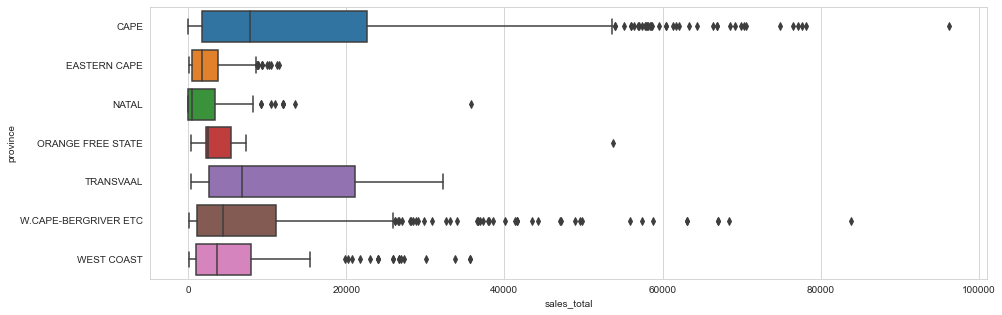

In [65]:
sns.boxplot(y="province", x="sales_total", data=train3)
plt.gcf().set_size_inches(15, 5)

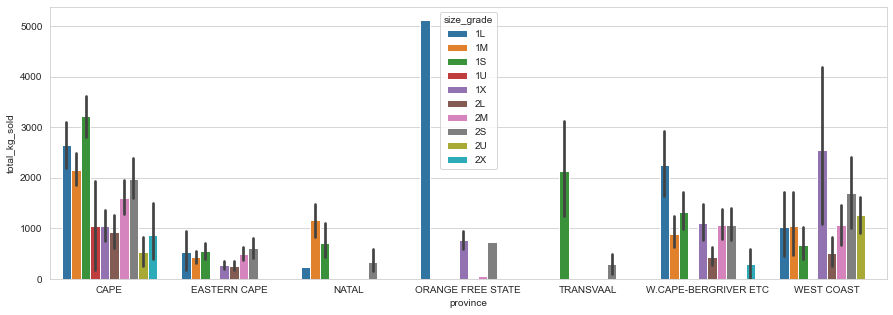

In [66]:
sns.barplot(x="province", y="total_kg_sold",hue = 'size_grade', data=train3)
plt.gcf().set_size_inches(15, 5)

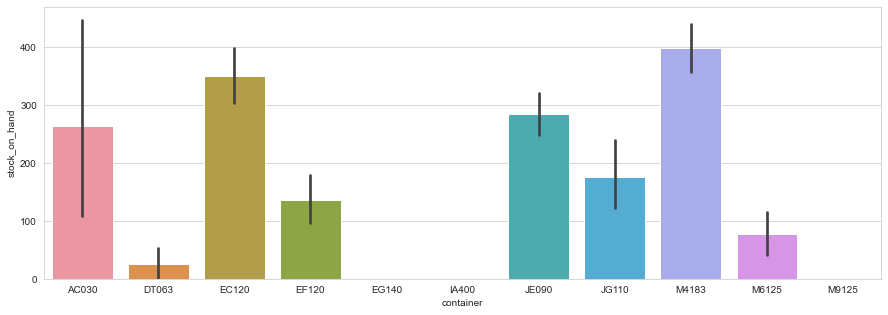

In [67]:
sns.barplot(x="container", y="stock_on_hand", data=train3)
plt.gcf().set_size_inches(15, 5)

### 3.5) Descriptive Statistical Analysis

In [68]:
train.describe(include=['category'])

,province,container,size_grade
count,1644,1644,1644
unique,7,10,10
top,CAPE,JE090,1S
freq,814,551,329


Value counts is a good way of understanding how many units we have for each variable. **NB:** value_counts() works only on a pandas series, not a pandas DataFrame.

However, we can convert the value count series into a DataFrame using to_frame().

In [69]:
province_counts = train['province'].value_counts().to_frame()
province_counts.rename(columns={'province': 'value_counts'}, inplace=True)
province_counts

,value_counts
CAPE,814
W.CAPE-BERGRIVER ETC,406
EASTERN CAPE,203
WEST COAST,125
NATAL,79
TRANSVAAL,10
ORANGE FREE STATE,7


In [70]:
#renaming the index to province
province_counts.index.name = 'province'
province_counts.head()

,value_counts
province,
CAPE,814
W.CAPE-BERGRIVER ETC,406
EASTERN CAPE,203
WEST COAST,125
NATAL,79


In [71]:
size_counts = train['size_grade'].value_counts().to_frame()
size_counts.rename(columns={'size_grade': 'value_counts'}, inplace=True)
size_counts

,value_counts
1S,329
1M,291
2S,279
2M,220
1L,198
1X,162
2L,120
2X,26
2U,17
1U,2


In [72]:
container_counts = train['container'].value_counts().to_frame()
container_counts.rename(columns={'container': 'value_counts'}, inplace=True)
container_counts

,value_counts
JE090,551
M4183,512
EC120,379
JG110,78
EF120,74
AC030,28
M6125,10
DT063,6
EG140,3
M9125,3


As we can see from all these 3 value_count dataframes of `'province'`, `'size_grade'` and `'container'`, the results are not skewed and hence the conclusion is that the 3 categorical features are reliable predictor variables of our respone variable `'avg_price_per-kg'`. 

### 3.5.1) Correlation and Causation

The p value is the evidence against a null hypothesis. The smaller the p-value, the stronger the evidence that you should reject the null hypothesis.

By convention, when the

- p-value is  <  0.001: we say there is strong evidence that the correlation is significant.
- the p-value is  <  0.05: there is moderate evidence that the correlation is significant.
- the p-value is  <  0.1: there is weak evidence that the correlation is significant.
- the p-value is  >  0.1: there is no evidence that the correlation is significant.

**Weight vs. Average Price per Kg**

In [73]:
pearson_coef, p_value = stats.pearsonr(train['weight_kg'], train['avg_price_per_kg'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.49283145272008233  with a P-value of P = 2.4749445901699414e-101


**_Conclusion_** **:** Since the P-value is far less than 0.001, we can conclude that the p value between weight and average price per kg is statistically signifigcant although the linear relationship isn't extremely strong.

**Low Price vs. Average Price per Kg**

In [74]:
pearson_coef, p_value = stats.pearsonr(train['low_price'], train['avg_price_per_kg'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.8184210843269901  with a P-value of P = 0.0


**_Conclusion_** **:** Since the P-value is far less than 0.001, we can conclude that the p value between low price and average price per kg is statistically signifigcant and the linear relationship is quite strong.

**High Price vs. Average Price per Kg**

In [75]:
pearson_coef, p_value = stats.pearsonr(train['high_price'], train['avg_price_per_kg'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.7660199018904634  with a P-value of P = 1.945522e-317


**_Conclusion_** **:** Since the P-value is far less than 0.001, we can conclude that the p value between weight and average price per kg is statistically signifigcant and the linear relationship is strong.

### 3.5.2) ANOVA 

Analysis of variance is a collection of statistical models and their associated estimation procedures used to analyze the differences among means of two or more groups. The ANOVA test from scipy.stats returns two results:

<p><b>F-test score</b>: ANOVA assumes the means of all groups are the same, calculates how much the actual means deviate from the assumption, and reports it as the F-test score. A larger score means there is a larger difference between the means.</p>

<p><b>P-value</b>:  P-value tells how statistically significant is our calculated score value.</p>

<p>If our price variable is strongly correlated with the variable we are analyzing, expect ANOVA to return a sizeable F-test score and a small p-value.</p>

**Provinces**

Since ANOVA analyzes the difference between different groups of the same variable, the groupby function will come in handy. Because the ANOVA algorithm averages the data automatically, we do not need to take the average before hand.

Let's see if different 'provinces' impact 'avg_price_per_kg.' We group the data.

In [76]:
grouped_provinces=train[['province', 'avg_price_per_kg']].groupby(['province'])
grouped_provinces.head(2)

,province,avg_price_per_kg
1,CAPE,8.51
7,CAPE,4.55
24,W.CAPE-BERGRIVER ETC,6.11
162,W.CAPE-BERGRIVER ETC,8.67
164,WEST COAST,6.15
428,EASTERN CAPE,6.74
456,NATAL,3.33
543,NATAL,3.33
732,EASTERN CAPE,8.78
1445,WEST COAST,4.44


Next we use the function 'f_oneway' in the module 'stats' to obtain the **F-test score** and **P-value**.

In [77]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_provinces.get_group('CAPE')['avg_price_per_kg'], grouped_provinces.get_group('W.CAPE-BERGRIVER ETC')['avg_price_per_kg'], 
                              grouped_provinces.get_group('WEST COAST')['avg_price_per_kg'], grouped_provinces.get_group('EASTERN CAPE')['avg_price_per_kg'],
                             grouped_provinces.get_group('NATAL')['avg_price_per_kg'], grouped_provinces.get_group('TRANSVAAL')['avg_price_per_kg'],
                             grouped_provinces.get_group('ORANGE FREE STATE')['avg_price_per_kg'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 74.71504599033922 , P = 1.4331859586388408e-82


As is turns out, this is a great result, our F-value of 77.15 indicates that the between-groups variance is over 77 times the size of the within-group variance. The null hypothesis value is that variances are equal, which produces an F-value of 1; The F-test score is showing a strong correlation and the result is almost 0 and we can infer that it's amost certain that the result is statistically significant.

**Size / Grade**

In [78]:
grouped_sizes=train[['size_grade', 'avg_price_per_kg']].groupby(['size_grade'])
grouped_sizes.head(1)

,size_grade,avg_price_per_kg
1,1L,8.51
7,2M,4.55
24,2S,6.11
40,1S,4.51
117,1M,8.33
258,1X,6.84
1265,2L,5.63
1671,2U,5.56
7521,2X,4.49
25227,1U,4.38


In [79]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_sizes.get_group('1L')['avg_price_per_kg'], grouped_sizes.get_group('2M')['avg_price_per_kg'], 
                              grouped_sizes.get_group('2S')['avg_price_per_kg'], grouped_sizes.get_group('1S')['avg_price_per_kg'],
                             grouped_sizes.get_group('1M')['avg_price_per_kg'], grouped_sizes.get_group('1X')['avg_price_per_kg'],
                              grouped_sizes.get_group('2L')['avg_price_per_kg'], grouped_sizes.get_group('2U')['avg_price_per_kg'],
                              grouped_sizes.get_group('2X')['avg_price_per_kg'], grouped_sizes.get_group('1U')['avg_price_per_kg'])
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 96.28934279553077 , P = 3.533873071374426e-144


The F-test score reveals that there's a strong correlation and this is statistically significant result since the P-value << 0.001. 

**Container**

In [80]:
grouped_containers=train[['container', 'avg_price_per_kg']].groupby(['container'])
grouped_containers.head(1)

,container,avg_price_per_kg
1,M4183,8.51
7,JG110,4.55
24,JE090,6.11
117,EC120,8.33
543,AC030,3.33
1046,M6125,8.00
1391,EF120,9.38
9265,DT063,9.52
31296,M9125,5.20
34499,EG140,8.14


In [81]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_containers.get_group('M4183')['avg_price_per_kg'], grouped_containers.get_group('JG110')['avg_price_per_kg'], 
                              grouped_containers.get_group('JE090')['avg_price_per_kg'], grouped_containers.get_group('EC120')['avg_price_per_kg'],
                             grouped_containers.get_group('AC030')['avg_price_per_kg'], grouped_containers.get_group('M6125')['avg_price_per_kg'],
                              grouped_containers.get_group('EF120')['avg_price_per_kg'], grouped_containers.get_group('DT063')['avg_price_per_kg'],
                              grouped_containers.get_group('M9125')['avg_price_per_kg'], grouped_containers.get_group('EG140')['avg_price_per_kg'])
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 86.51925304415373 , P = 1.3863038471914423e-131


Again, the F-test score reveals that there's a strong correlation and this is statistically significant result since the P-value << 0.001.

**We may now conlude that the useful features we can use for building machine learning models are:**

- low price
- high price 
- province 
- size_grade
- container

Feeding machine learning models with variables that meaningfully affect our target variable will improve our model's prediction accuracy. 

However, we have to first encode `'province'`, `'size_grade'` and `'container'` features with **dummy variables**, because regression models understand numbers not words or strings.

In [82]:
dummy_df = pd.get_dummies(train[["province", "size_grade", "container"]])

In [83]:
# merge with main df on key values
train = pd.concat([train, dummy_df], axis=1)
train.head()

,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,total_qty_sold,...,container_DT063,container_EC120,container_EF120,container_EG140,container_IA400,container_JE090,container_JG110,container_M4183,container_M6125,container_M9125
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,...,0,0,0,0,0,0,0,1,0,0
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,...,0,0,0,0,0,0,1,0,0,0
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,...,0,0,0,0,0,1,0,0,0,0
40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-05-04,80.0,120.0,32020.0,388,...,0,0,0,0,0,0,0,1,0,0
80,CAPE,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-03-13,55.0,55.0,4840.0,88,...,0,0,0,0,0,1,0,0,0,0


Now we can drop non-numerical columns in our dataframe.

In [84]:
train = train.drop(columns=["commodities", "province", "size_grade", "container"], axis=1)

In [85]:
train.head()

,weight_kg,date,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg,month,...,container_DT063,container_EC120,container_EF120,container_EG140,container_IA400,container_JE090,container_JG110,container_M4183,container_M6125,container_M9125
1,18.3,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51,9,...,0,0,0,0,0,0,0,1,0,0
7,11.0,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55,4,...,0,0,0,0,0,0,1,0,0,0
24,9.0,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11,4,...,0,0,0,0,0,1,0,0,0,0
40,18.3,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51,5,...,0,0,0,0,0,0,0,1,0,0
80,9.0,2020-03-13,55.0,55.0,4840.0,88,792.0,181,6.11,3,...,0,0,0,0,0,1,0,0,0,0


In [86]:
train.columns

Index(['weight_kg', 'date', 'low_price', 'high_price', 'sales_total',
       'total_qty_sold', 'total_kg_sold', 'stock_on_hand', 'avg_price_per_kg',
       'month', 'province_CAPE', 'province_EASTERN CAPE', 'province_NATAL',
       'province_ORANGE FREE STATE', 'province_TRANSVAAL',
       'province_W.CAPE-BERGRIVER ETC', 'province_WEST COAST', 'size_grade_1L',
       'size_grade_1M', 'size_grade_1S', 'size_grade_1U', 'size_grade_1X',
       'size_grade_2L', 'size_grade_2M', 'size_grade_2S', 'size_grade_2U',
       'size_grade_2X', 'container_AC030', 'container_DT063',
       'container_EC120', 'container_EF120', 'container_EG140',
       'container_IA400', 'container_JE090', 'container_JG110',
       'container_M4183', 'container_M6125', 'container_M9125'],
      dtype='object')

## 4) Feature Engineering

We can still come up with even more useful features to feed into our machine learning models, via a process known as feature engineering. First we create a baseline model and see how it improves when we include the new features that we create. The usefulness of a feature depends on the type of model that you will use. A feature is only useful to the extent that its relationship with the target is one your model can learn.  

In [87]:
#Baseline Model
baseline= RandomForestRegressor(criterion="mse", random_state=0)

In [88]:
rmse_cross_neg = cross_val_score(baseline, train[['low_price', 'high_price']], 
                                train['avg_price_per_kg'], cv=5, scoring='neg_mean_squared_error')

rmse_baseline = - 1 * rmse_cross_neg 
rmse_baseline

array([0.6311407 , 0.70239787, 0.77096452, 0.83645142, 0.79377915])

In [89]:
print("The mean of the cross-validation folds is ", rmse_baseline.mean(), "and the standard deviation is ", rmse_baseline.std())

The mean of the cross-validation folds is  0.7469467336305181 and the standard deviation is  0.07235586732333443


From the supply and demand economic model, we may expect that if the demand of golden delicious apples is low and the supply is high, then average price of the apples will be low and viceversa. What we need is a way to quantify the demand and supply in terms of the given features.

We expect that the *more* the quantity that's sold, the _*higher* the supply_ and the _*lower* the demand_. The *less* the quatity that's sold, the _*higher* the demand_ and the _*lower* the supply_.

One way companies determine how to price their goods is to look at the demand curve and calculate the potential revenue and profit at various prices and quantities:
$$
(Revenue) = (Quantity Sold) * (Price)
$$
                                              
So it seems plausible that a ratio of our `'sales_total'` and `'total_qty_sold'` might give us and idea about the price of apples. We may also try to include the `'weight_kg'` feature, since our target variable has units of kg as well.

In [90]:
train['price_kg'] = train['sales_total'] * train['weight_kg'] / train['total_qty_sold']  

Since most of the values in our data set are from the year 2020, we may therefore try to seek a pattern of the month and the average price per kg. Intuitively, one might expect less apples purchased during strict lockdown levels implemented by the South African government during the pandemic. 

In [91]:
train['month'] = train['date'].dt.month

In [92]:
model = RandomForestRegressor(criterion="mse", random_state=0)

In [93]:
rmse_cross_neg = cross_val_score(model, train[[ 'low_price', 'high_price', 'month', 'price_kg']], 
                                train['avg_price_per_kg'], cv=5, scoring='neg_mean_squared_error')

rmse_model = - 1 * rmse_cross_neg
rmse_model

array([0.31722529, 0.19934817, 0.0920479 , 0.1476537 , 0.1714207 ])

In [94]:
print("The mean of the cross-validation folds is ", rmse_model.mean(), "and the standard deviation is ", rmse_model.std())

The mean of the cross-validation folds is  0.18553915389159675 and the standard deviation is  0.07470900853135018


There's been a huge decrease in rmse, this is evidence enough that the `month` and `price_kg` features have exposed some new information and patterns that were not caught by the model before.

Now let's see what happens when we have dummy variables that we created with the get_dummies method to our model.

In [95]:
ind_var_df = train.drop(columns=["date", "avg_price_per_kg"], axis=1)

In [96]:
rmse_cross_neg = cross_val_score(model, ind_var_df, 
                                train['avg_price_per_kg'], cv=5, scoring='neg_mean_squared_error')

rmse_model = - 1 * rmse_cross_neg
rmse_model

array([0.17285038, 0.04821442, 0.02484592, 0.10296577, 0.07049212])

In [97]:
print("The mean of the cross-validation folds is ", rmse_model.mean(), "and the standard deviation is ", rmse_model.std())

The mean of the cross-validation folds is  0.08387372464074425 and the standard deviation is  0.051412618611875606


Again, the rmse error is reduced when we include our dummy variables, this is also evidence that letting the model know the province, container and size of apples lets it make better prediction, this was expected.

## 5) Model Development

In this section, we will develop several models that will predict the average price per kg of Golden Delicious Apples using the variables or features that will meaningfully impact our model.

In Data Analytics, we often use **Model Development** to help us predict future observations from the data we have.

A Model will help us understand the exact relationship between different variables and how these variables are used to predict the result.

## 5.1) Model Evaluation

### 5.1.1) Preprocessing

We have to rescale our data, since because scaling data is a crucial first step to regularisation as the penalty on particular coefficients in regularisation techniques namely ridge regression and lasso regression, depends largely on the scale associated with the variables. There are two common methods to scale data (MinMaxScaler and StandardScaler). We will use standard scaler to scale our data, because it is more robust to ouliers.

In [98]:
from sklearn.preprocessing import StandardScaler

In [99]:
y_data = train['avg_price_per_kg']
x_data = train.drop(columns= ['date','avg_price_per_kg'], axis=1)

In [100]:
scaler = StandardScaler()

In [101]:
X_scaled = scaler.fit_transform(x_data)

In [102]:
X_standardise = pd.DataFrame(X_scaled,columns=x_data.columns)
X_standardise.describe().loc['std']

weight_kg                        1.000304
low_price                        1.000304
high_price                       1.000304
sales_total                      1.000304
total_qty_sold                   1.000304
total_kg_sold                    1.000304
stock_on_hand                    1.000304
month                            1.000304
province_CAPE                    1.000304
province_EASTERN CAPE            1.000304
province_NATAL                   1.000304
province_ORANGE FREE STATE       1.000304
province_TRANSVAAL               1.000304
province_W.CAPE-BERGRIVER ETC    1.000304
province_WEST COAST              1.000304
size_grade_1L                    1.000304
size_grade_1M                    1.000304
size_grade_1S                    1.000304
size_grade_1U                    1.000304
size_grade_1X                    1.000304
size_grade_2L                    1.000304
size_grade_2M                    1.000304
size_grade_2S                    1.000304
size_grade_2U                    1

As we can see, the variance of our features is now equal to one after standardization. Which is expected.

### 5.2) Training and Testing

Now we randomly split our data into training and testing data using the function train_test_split.

In [103]:
x_train, x_test, y_train, y_test = train_test_split(X_standardise, y_data, test_size=0.2, random_state=1)

In [104]:
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 329
number of training samples: 1315


#### Model 1: Linear Regression

<p>Simple Linear Regression is a method to help us understand the relationship between two variables:</p>
<ul>
    <li>The predictor/independent variable (X)</li>
    <li>The response/dependent variable (that we want to predict)(Y)</li>
</ul>

In [105]:
lre = LinearRegression()

In [106]:
lre.fit(x_train[['low_price']], y_train)

LinearRegression()

In [107]:
# R^2 on test data 
lre.score(x_test[['low_price']], y_test)

0.6888682867119678

In [108]:
# R^2 on train data 
lre.score(x_train[['low_price']], y_train)

0.6640559911513765

In [109]:
# Prediction using train data:
y_hat_train_1 = lre.predict(x_train[['low_price']])
y_hat_train_1[0:5]

array([ 5.82201774,  5.253918  , 10.55618227,  6.76885065,  5.63265116])

In [110]:
# Prediction using test data:
y_hat_test_1 = lre.predict(x_test[['low_price']])
y_hat_test_1[0:5]

array([8.66251646, 6.01138432, 5.63265116, 6.01138432, 4.11771851])

In [111]:
# RSME on training data 
train_rmse = math.sqrt(mean_squared_error(y_train, y_hat_train_1))
train_rmse

1.215907009963401

In [112]:
#RSME on test data
test_rsme = math.sqrt(mean_squared_error(y_test, y_hat_test_1))
test_rsme

1.1987124426215459

#### Model 2: Multiple Linear Regression

If we want to predict the average price per kg of Golden Delicious apples using more than one variable we use Multiple Linear Regression.

The following function does the previous steps of model 1. Since the process becomes quit repetitive. We just have to instantiate the model's object and pass it into the function along with the specified x_train and x_test data.

In [113]:
def train_and_eval (model, X_train, X_test, Y_train = y_train, Y_test = y_test):
    # fit model to data/train model
    model.fit(X_train, Y_train) 
    # prediction on train data
    Yhat_train = model.predict(X_train)
    # prediction on test data
    Yhat_test = model.predict(X_test)
    # train rmse 
    rmse_train = math.sqrt(mean_squared_error(Y_train, Yhat_train))
    # test rmse 
    rmse_test = math.sqrt(mean_squared_error(Y_test, Yhat_test))
    estimates_dict = {'R^2 on train data': [model.score(X_train, Y_train)], 'R^2 on test data': [model.score(X_test, Y_test)],
                     'RMSE on train data': [rmse_train], 'RMSE on test data': [rmse_test]}
    estimates_df = pd.DataFrame(estimates_dict, index = ['Metric Value'])
    return estimates_df

In [114]:
lre_multiple = LinearRegression()

In [115]:
train_and_eval(lre_multiple, x_train, x_test)

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.910186,0.91551,0.628694,0.624664


As we can see, multiple linear regression has a much lower score when we use more features instead of just one as this exposes more information to our linear regression model.

#### Model 3: Polynomial Regression

Here we simply use a pipeline instead of our 'train_and_eval' function. Since the polynomial regression object has no .fit() method which is within our defined function.

In [116]:
from sklearn.pipeline import Pipeline

In [117]:
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model',LinearRegression())]
pipe=Pipeline(Input)
pipe

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

For our polynomial features, we cannot use all the dummy variable features, as this requires 329GiB / 353,261 GB, because with polynomial features we have cross terms. In our case, we have a cross term that's an array with shape (1370, 32224113) and data type float64. So we will just use `'low_price`, `high_price`, `month` and `price_kg`.


In [118]:
pipe.fit(x_train[['low_price', 'high_price', 'month', 'price_kg']], y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [119]:
# prediction on train
ypipe_train=pipe.predict(x_train[['low_price', 'high_price', 'month', 'price_kg']])
ypipe_train[0:4]

array([5.87086746, 5.51617751, 9.76635169, 8.14013866])

In [120]:
# prediction on test
ypipe_test=pipe.predict(x_test[['low_price', 'high_price', 'month', 'price_kg']])
ypipe_test[0:4]

array([8.40414935, 6.52103297, 6.01873484, 6.32934171])

In [121]:
metrics_dict = {'R^2 on train data': [r2_score(y_train, ypipe_train)], 'R^2 on test data': [r2_score(y_test, ypipe_test)],
                     'RMSE on train data': [math.sqrt(mean_squared_error(y_train , ypipe_train))], 
                'RMSE on test data': [math.sqrt(mean_squared_error(y_test, ypipe_test))]}
metrics_df = pd.DataFrame(metrics_dict, index = ['Metric Value'])
metrics_df

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.879925,0.882102,0.726931,0.737897


The polynomial regression model using a polynomial of order 3 and using only the four features that we gave it doesn't do any much better than multiple linear regression on test data.

We can make a plot to see if we have used the best order for our polynomial.

Text(0.5, 1.0, 'R^2 Using Test Data')

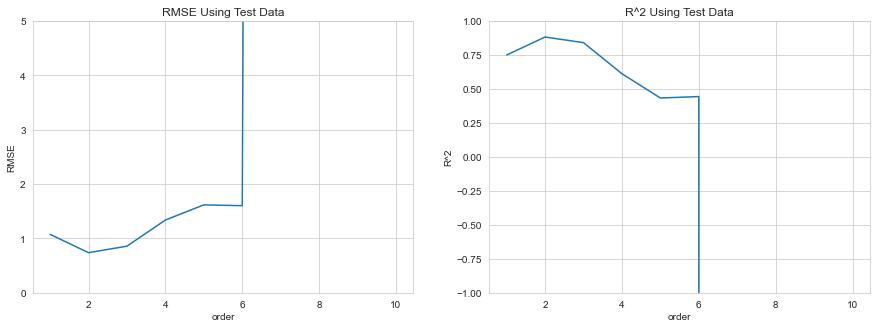

In [122]:
rmse_test = []
rsqd_test = []
order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n in order:
    Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=n, include_bias=False)), ('model',LinearRegression())]
    pipe=Pipeline(Input)
    pipe.fit(x_train[['low_price', 'high_price', 'month', 'price_kg']], y_train)
    ypipe_test = pipe.predict(x_test[['low_price', 'high_price', 'month', 'price_kg']])
    rmse_test.append(math.sqrt(mean_squared_error(y_test , ypipe_test)))
    rsqd_test.append(r2_score(y_test, ypipe_test))

# Create figure and axes
f, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2, sharey=False)

# Create list of titles
title = ['RMSE Using Test Data','R^2 Using Test Data']

# Plot the subplots
ax[0].set_ylim([0, 5])
ax[0].set_xlabel('order')
ax[0].set_ylabel('RMSE')
ax[0].plot(order, rmse_test)
ax[0].set_title(title[0])

ax[1].set_ylim([-1, 1])
ax[1].set_xlabel('order')
ax[1].set_ylabel('R^2')
ax[1].plot(order, rsqd_test)
ax[1].set_title(title[1])

Clearly a polynomial of **degree three** will minimize the RMSE on test data and maximize the R$^{2}$ as well. We use these graphs to find the optimal parameters to use for PolynomialFeatures. 

#### Model 4: Decision Tree

In [123]:
dtr= DecisionTreeRegressor(max_depth=5, random_state=42)

In [124]:
train_and_eval(dtr, x_train, x_test)

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.908595,0.882448,0.634237,0.736813


The decision tree alone doesn't do any better than the multiple linear regression model on test data. We can however use random forests, which is an ensemble learning method that may significantly improve our results. 

#### Model 5: Random Forests

Let's use the Random Forest model and see how the RMSE on test data is like. We will use the same max_depth number as we used on the decision tree above.

In [125]:
rf = RandomForestRegressor(n_estimators=500, max_depth=5)

In [126]:
train_and_eval(rf, x_train, x_test)

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.955951,0.942056,0.440286,0.517304


As expected, the random forest mode has a much lower RMSE on test data than a single decision tree, simply by averaging the predictions of many decision trees. Also it turns out that our random forest model has the lowest RMSE on test data so far. Furtheremore, this RMSE can be further lowered by hyperparameter tunning. Which we will do in the next section. See the subsection called **Grid Search**.

#### Model 6: Support Vector Regressor

In [127]:
sv_reg = SVR(kernel='rbf', gamma='auto')

In [128]:
train_and_eval(sv_reg, x_train, x_test)

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.934925,0.915996,0.535149,0.622862


The support vector regressor doesn't do well enough on the test data compared to the random forest regressor. This may be because the random forest regressor is an ensemble learning model and the suport vector regressor is not.

#### Model 7: XGBoost

XGBoost is the most accurate modelling technique for structured data. This is especially true when we carefully tune it's parameters.

**Gradient boosting** is an ensemble method. It is a type of machine learning boosting. It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. The key idea is to set the target outcomes for this next model in order to minimize the error. In tree boosting, each new model that is added to the ensemble is a decision tree. XGBoost provides parallel tree boosting (also known as GBDT, GBM) that solves many data science problems in a fast and accurate way. For many problems, XGBoost is one of the best gradient boosting machine (GBM) frameworks today.

We first have to initialize our ensemble model with a single model (even if the predictions are very innacurate, the later additions of models into the ensemble will minimize those errors for us.

After initializing our ensemble model with a single model, we start the cycle:

- First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
- These predictions are used to calculate a loss function (like the mean squared error, for instance).
- Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss. (Side note: The "gradient" in "gradient boosting" refers to the fact that we'll use gradient descent on the loss function to determine the parameters in this new model.)
- Finally, we add the new model to ensemble then repeat the cycle all over again.

In [129]:
#initialize ensemble with a single model
my_model = XGBRegressor()
my_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Here are descriptions of the parameters of the XGBRegressor:
- `n_estimators` specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.
- `early_stopping_rounds` offers a way to automatically find the ideal value for n_estimators. Early stopping causes the model to stop iterating when the validation score stops improving. When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores - this is done by setting the `eval_set` parameter.
- `learn_rate`specifies the learning rate by which to shrink the feature weights. Shrinking feature weights after each boosting step makes the boosting process more conservative and prevents overfitting. The range is 0.0 to 1.0. This value defaults to 0.3. In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle.
- `objective`: This defines the loss function to be minimized.

For more info on other parameters, see [XGBoost paarmeters](https://xgboost.readthedocs.io/en/latest/parameter.html).

In [130]:
# generate prediction with the single model ensemble
predictions = my_model.predict(x_test)
print("Mean Squared Error: " + str(mean_squared_error(predictions, y_test)))

Mean Squared Error: 0.02674388723546124


C:\Users\vnbri\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [131]:
# fit in new models to the ensemble
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(x_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(x_test, y_test)],
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [132]:
predictions = my_model.predict(x_test)
print("Mean Squared Error: " + str(mean_squared_error(predictions, y_test)))

Mean Squared Error: 0.02470545555263041


C:\Users\vnbri\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


The RMSE of the test data with XGBoost may further be lowered with the help of hyperparameter tunning as well. 

#### Ensemble Learning 

In [133]:
from sklearn.ensemble import VotingRegressor

In [134]:
models = [("LR",lre),("DT",dtr),("SVR",sv_reg)]

In [135]:
model_weightings = np.array([0.1,0.3,0.6])
v_reg = VotingRegressor(estimators=models,weights=model_weightings)

At this point, we have built a voting-based ensemble that combines:
- 10% of Linear Regression model output
- 30% of Decision Tree output
- 60% of Support Vector Regression output

to make a final prediction.

In [136]:
v_reg.fit(x_train, y_train)

VotingRegressor(estimators=[('LR', LinearRegression()),
                            ('DT',
                             DecisionTreeRegressor(max_depth=5,
                                                   random_state=42)),
                            ('SVR', SVR(gamma='auto'))],
                weights=array([0.1, 0.3, 0.6]))

In [137]:
train_and_eval(v_reg, x_train, x_test)

,R^2 on train data,R^2 on test data,RMSE on train data,RMSE on test data
Metric Value,0.950802,0.93377,0.465308,0.553056


### _Results Summary_

|   Model  |       Train RMSE      | Test RMSE | 
|-------------------|---------------|---------------|
| Linear Regression   |     1.215907    |   1.1987124  |
| Multiple Linear Regression |   0.628694  |  0.624664 |
| Polynomial Regression (Cubic)  |  0.634023  |	0.858077 |
| Decision Tree Regressor |   0.634237 |  0.736813  |
| Support Vector Regressor |     0.535149 | 0.622862  |
| Random Forest Regressor | 0.430385  |	0.508592 |
| Voting (LR + MLR + SVR) |   0.465308    |    0.553056    |
| XGBoost |      |    0.0247058    |

## 6) Model Selection

### Ridge Regression

In [138]:
pr=PolynomialFeatures(degree=3)
x_train_pr = pr.fit_transform(x_train[['low_price', 'high_price', 'month', 'price_kg']])
x_test_pr = pr.fit_transform(x_test[['low_price', 'high_price', 'month', 'price_kg']])

In [139]:
RidgeModel=Ridge(alpha=0.1)

In [140]:
RidgeModel.fit(x_train_pr, y_train)

Ridge(alpha=0.1)

In [141]:
yhat = RidgeModel.predict(x_test_pr)
yhat[0:5]

array([7.94060183, 6.54935351, 7.43487908, 6.49674815, 1.32005123])

In [142]:
print('The first 5 predicted values: ', yhat[0:5], '\n The actual/test values are ', y_test[0:5].values)

The first 5 predicted values:  [7.94060183 6.54935351 7.43487908 6.49674815 1.32005123] 
 The actual/test values are  [ 8.08  7.14 10.08  6.67  1.11]


In [143]:
Rsqu_test = []
Rsqu_train = []
dummy1 = []
alpha_params = 10 * np.array(range(0,1000))
for alfa in alpha_params:
    RigeModel = Ridge(alpha=alfa) 
    RigeModel.fit(x_train_pr, y_train)
    Rsqu_test.append(RigeModel.score(x_test_pr, y_test))
    Rsqu_train.append(RigeModel.score(x_train_pr, y_train))

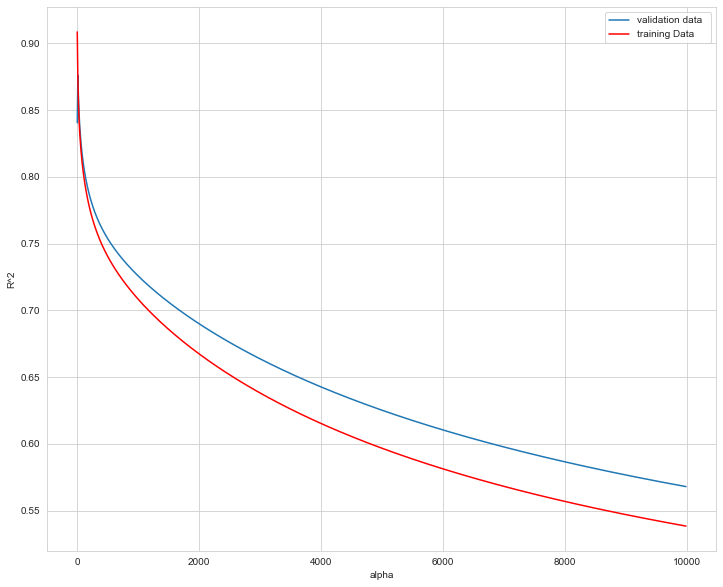

In [144]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(alpha_params,Rsqu_test, label='validation data  ')
plt.plot(alpha_params,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

### Grid Search

#### Ridge Regression

In [145]:
alpha_params1= [{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000]}]
alpha_params1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000]}]

In [146]:
rr = Ridge()
rr

Ridge()

In [147]:
grid_rr = GridSearchCV(rr, alpha_params1, cv=5)

In [148]:
grid_rr.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000]}])

In [149]:
BestRR=grid_rr.best_estimator_
BestRR

Ridge(alpha=10)

In [150]:
math.sqrt(mean_squared_error(y_test, BestRR.predict(x_test)))

0.6310402649438781

The test RSME of ridge regression is lower than that of some models, but not any lower than that of the ensemble models that we used in this notebook.

#### Random Forest Regressor

We will use all of the data instead of the train and validation set data.

In [151]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20, 40, 70, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [4, 6, 8, 10],
    'n_estimators': [200, 300, 400, 500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_rf.fit(x_train, y_train)

In [ ]:
BestRF = grid_rf.best_estimator_
BestRF

In [ ]:
# RMSE on test data for random forest
math.sqrt(mean_squared_error(y_test, BestRF.predict(x_test)))

#### XGBoost 

Here are brief descriptions of other relevant parameters of XGBoost that are not yet explained in this notebook:
- **booster**: Select the type of model to run at each iteration
    gbtree: tree-based models
    gblinear: linear models
- **nthread**: default to maximum number of threads available if not set
- **objective**: This defines the loss function to be minimized

Parameters that control the computation speed

- **subsample**: Denotes the fraction of observations to be randomly samples for each tree
- **colsample_bytree**: Subsample ratio of columns when constructing each tree.
- **n_estimators**: Number of trees to fit.

Parameters which control the bias and variance trade-off (underfitting and overfitting). 

- **learning_rate**: Makes the model more robust by shrinking the weights on each step
- **max_depth**: The maximum depth of a tree.
- **min_child_weight**: Defines the minimum sum of weights of all observations required in a child.

In [ ]:
#XGBoost hyper-parameter tuning
param_tuning = {
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [2, 4, 6],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror'],
    }
xgb_model = XGBRegressor()

grid_xgb = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1)

grid_xgb.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)])

In [ ]:
best_XGB = grid_xgb.best_estimator_
best_XGB

In [ ]:
# rmse of test data for XGBoost
math.sqrt(mean_squared_error(y_test, best_XGB.predict(x_test)))

As we can see, the XGBoost model out performs all the other models after hyperparameter tunnning; it has the lowest RSME score on the test data. 

### _Conclusion_

The conclusion here is that the best model to use is XGBoost, since it has the best result on the desired metric on test data after careful parameter tunning, i.e XGBoost gives the lowest RMSE on test data. In addition, we saw that it gave us the best $R^{2}$ value, i.e it gave us the highest $R^{2}$.

# Predictions

Now we will make some predictions on the actual test set.

In [154]:
test.shape

(685, 13)

There are 685 observations and 13 features just as in the original train dataframe.

In [155]:
test.isnull().sum()

Index             0
Province          0
Container         0
Size_Grade        0
Weight_Kg         0
Commodities       0
Date              0
Low_Price         0
High_Price        0
Sales_Total       0
Total_Qty_Sold    0
Total_Kg_Sold     0
Stock_On_Hand     0
dtype: int64

As, expected, there are no missing values in this test set.

In [156]:
#fixing the 'Date' column in the test dataset
test['Date'] = pd.to_datetime(test['Date'], format="%Y.%m.%d") 

The `Date` column is not in the correct format and we need to change it to the `datetime` format just as we did for the train dataframe.

In [157]:
dummy_test = pd.get_dummies(test[['Province', 'Size_Grade', 'Container']])
test = pd.concat([test, dummy_test], axis=1)

We also had to create the dummy variables for the test set, because our regression models understand numbers not words.

In [158]:
test['price_kg'] = test['Sales_Total'] * test['Weight_Kg'] / test['Total_Qty_Sold']  
test['month'] = test['Date'].dt.month

In [159]:
test.columns

Index(['Index', 'Province', 'Container', 'Size_Grade', 'Weight_Kg',
       'Commodities', 'Date', 'Low_Price', 'High_Price', 'Sales_Total',
       'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand', 'Province_CAPE',
       'Province_EASTERN CAPE', 'Province_NATAL', 'Province_ORANGE FREE STATE',
       'Province_TRANSVAAL', 'Province_W.CAPE-BERGRIVER ETC',
       'Province_WEST COAST', 'Size_Grade_1L', 'Size_Grade_1M',
       'Size_Grade_1S', 'Size_Grade_1U', 'Size_Grade_1X', 'Size_Grade_2L',
       'Size_Grade_2M', 'Size_Grade_2S', 'Size_Grade_2U', 'Size_Grade_2X',
       'Container_AC030', 'Container_DT063', 'Container_EC120',
       'Container_EF120', 'Container_EG140', 'Container_IA400',
       'Container_JE090', 'Container_JG110', 'Container_M4183',
       'Container_M6125', 'Container_M9125', 'price_kg', 'month'],
      dtype='object')

In [160]:
# Drop non-numerical columns

test.drop(columns=['Province', 'Size_Grade', 'Container', 'Commodities', 'Date'], axis=1, inplace=True)

There is a column that's not in the train dataframe after using get dummies. The column is `'Container_IA00'`. A for-loop may be used to detect other missing columns, but after making the column names lower cases and this lowering of cases has to happen before using get dummies on the test set.

In [161]:
test.drop(columns=['Container_IA400'], axis=1, inplace=True)

In [162]:
#model = Ridge(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=None,
#      normalize=False, random_state=None, solver='auto', tol=0.001)
model = XGBRegressor(colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7, 
                     learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000,
                     objective='reg:squarederror', random_state=0, subsample=0.7)
model.fit(x_train, y_train)
                
preds = model.predict(test)
preds[0:5]

C:\Users\vnbri\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


array([12.47394 ,  8.630675, 12.479189, 12.488526, 12.470257],
      dtype=float32)

We import the model as a pickle file for the API to use.

In [163]:
#import pickle 

#model_save_path = "model.pkl"
#with open(model_save_path,'wb') as file:
#    pickle.dump(model,file)

# Submission

In [164]:
index = test['Index']

In [165]:
# create submission dataframe
submission = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': preds
    })

submission.head()

,Index,avg_price_per_kg
0,1,12.473940
1,2,8.630675
2,3,12.479189
3,4,12.488526
4,5,12.470257


In [ ]:
#Save DataFrame to csv file for submission
submission.to_csv("submission.csv", index=False)

# END OF NOTEBOOK